# Solution: How calibrations inform policy

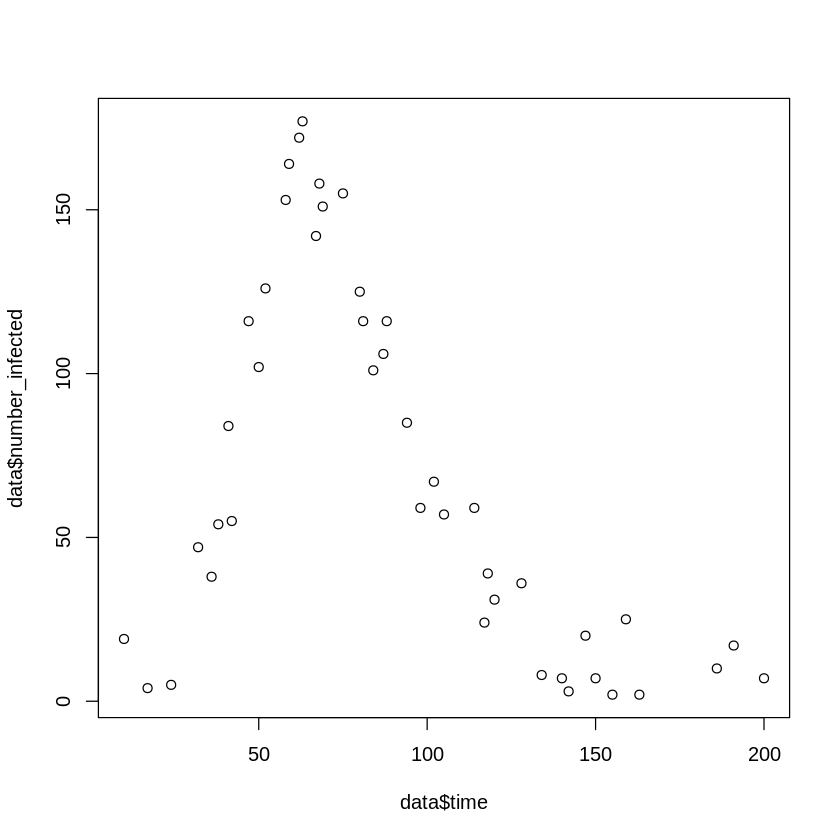

In [1]:
# Loading and exploring the dataset
data <- read.csv("../../IDM2/Graphics and Data/w7_nb3_data.csv")

plot(data$time, data$number_infected)

Plotting the dataset, this look like an epidemic curve for an outbreak starting with the introduction of one infected case. We have datapoints of the prevalence of infection spanning the entire duration of the epidemic (200 days), but not for every day.

Define the simple SIR model and model input:

In [2]:
# PACKAGES
require(deSolve)
require(ggplot2)

# INPUT
initial_state_values <- c(S = 499,         # the total population size is 500
                          I = 1,       
                          R = 0)

times <- seq(from = 0, to = 200, by = 1)   # the outbreak lasts 200 days

# SIR MODEL FUNCTION
sir_model <- function(time, state, parameters) {  
  
  with(as.list(c(state, parameters)), {
    
    N <- S+I+R
    
    lambda <- beta * I/N
    
    # The differential equations
    dS <- -lambda * S               
    dI <- lambda * S - gamma * I
    dR <- gamma * I             
    
    # Output
    return(list(c(dS, dI, dR))) 
  })
}

Loading required package: deSolve
Loading required package: ggplot2


Then, define a function that simulates the model for a given combination of parameters and calculates the sum-of-squares for the epidemic curve:

In [3]:
## DISTANCE FUNCTION 
SIR_SSQ <- function(parameters, dat) {  # takes as inputs the parameter values and dataset
    
   beta <- parameters[1]    # extract and save the first value in the "parameters" input argument as beta
   gamma <- parameters[2]   # extract and save the second value in the "parameters" input argument as gamma
    
   # Simulate the model with initial conditions and timesteps defined above, and parameter values from function call
   output <- as.data.frame(ode(y = initial_state_values, 
                               times = times, 
                               func = sir_model,
                               parms = c(beta = beta,       # ode() takes the values for beta and gamma extracted from
                                         gamma = gamma)))   # the "parameters" input argument of the SIR_SSQ() function
    
   # Calculate the sum of squares by comparing the model output with the matching datapoints:
   # This involves, for each timepoint with available data, calculating the difference between the number of infections
   # predicted by the model and the observed number of infections, squaring all these differences, and taking the 
   # sum of all squared differences
   SSQ <- sum((output$I[output$time %in% dat$time]-dat$number_infected)^2)
    
   return(SSQ)
    
}

Optimise the sum-of-squares function using the ```optim()``` command to find the values for $\beta$ and $\gamma$ giving the lowest sum of squares value as output:

In [4]:
optim(par = c(0.1, 0.1),           # chose sensible starting values for beta and gamma
      fn = SIR_SSQ,                # the distance function to optimise
      dat = data)                  # the dataset to fit to ("dat" argument is passed to the function specified in fn)

$par
[1] 0.16036500 0.04973925

$value
[1] 5160.719

$counts
function gradient 
      61       NA 

$convergence
[1] 0

$message
NULL

### What are the best-fitting values for $\beta$ and $\gamma$?

The ```optim()``` algorithm estimates $\beta$ = 0.16 and $\gamma$ = 0.05 per day, giving a minimum sum-of-squares value of 5161.
We can confirm visually that this parameter set produces a good model fit to the data, by overlaying the datapoints on a plot of the model output:

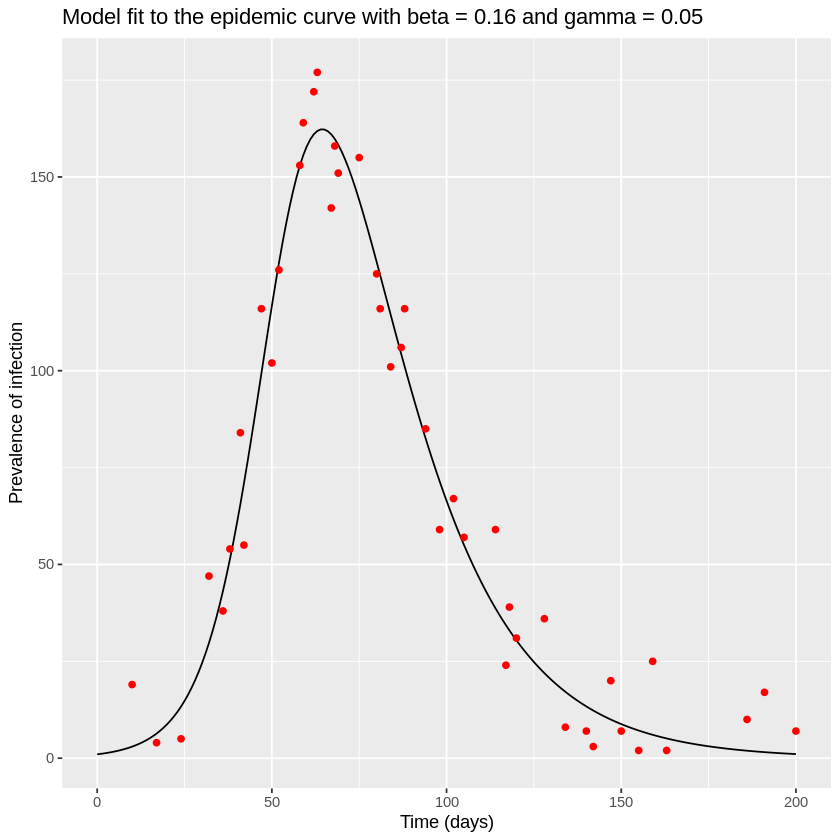

In [5]:
# Simulate the model with the estimated best-fitting parameter values
parameters <- c(beta = 0.16,
                gamma = 0.05)

output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters))

# PLOT OF THE MODEL FIT

ggplot() +
  geom_line(data = output, aes(x = time, y = I)) +                              
  geom_point(data = data, aes(x = time, y = number_infected), col = "red") +  
  xlab("Time (days)")+                                              
  ylab("Prevalence of infection") +                                 
  labs(title = paste("Model fit to the epidemic curve with beta =", parameters["beta"], 
                     "and gamma =", parameters["gamma"]))

### Based on your estimates parameter values, what would be the critical vaccination threshold required to prevent this epidemic, assuming an all-or-nothing vaccine with 75% efficacy?

We can calculate the critical **effective** vaccination coverage as:

\begin{align}
p_{eff} & = 1-\frac{1}{R_0} \\
 & = 1-\frac{1}{\frac{\beta}{\gamma}} \\
 & = 1-\frac{0.05}{0.16} \\
 & = 0.69
\end{align}

Since the all-or-nothing vaccine is only 75% effective, we can calculate the critical vaccination threshold as:
\begin{align}
p_{c} & = \frac{p_{eff}}{v_{eff}} \\
 & = \frac{0.69}{0.75} \\
 & = 0.92
\end{align}

To interrupt transmission and bring R<sub>0</sub> below 1, 92% of the population would have to be vaccinated. We can confirm the absence of an epidemic under these conditions using the simulation code:

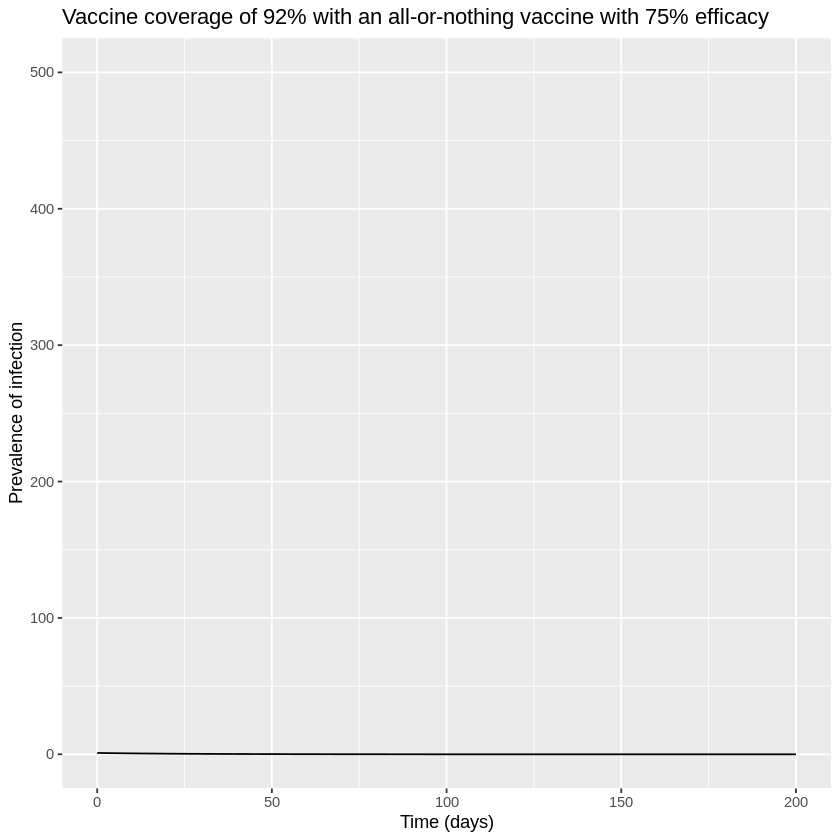

In [6]:
initial_state_values <- c(S = 0.08*499,         # only 8% of the population are susceptible
                          I = 1,       
                          R = 0.92*499)         # 92% of the population are vaccinated/immune

output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters))

# PLOT OF THE MODEL FIT

ggplot() +
  geom_line(data = output, aes(x = time, y = I)) +                              
  xlab("Time (days)")+                                              
  ylab("Prevalence of infection") + 
  labs(title = "Vaccine coverage of 92% with an all-or-nothing vaccine with 75% efficacy") +
  ylim(c(0,500))                         